In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as lines
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun13_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x
    

In [4]:
def pz_smear(pz):
    pz_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                pz_perc = random.gauss(1,0.0404);
            elif element <= 100: 
                pz_perc = random.gauss(1,0.0410);
            elif element <= 250: 
                pz_perc = random.gauss(1,0.0415);
            elif element <= 500: 
                pz_perc = random.gauss(1,0.0420);
            elif element <= 1000: 
                pz_perc = random.gauss(1,0.0435);
            elif element <= 2000:  
                pz_perc = random.gauss(1,0.0477);
            elif element <= 3000:  
                pz_perc = random.gauss(1,0.0523);
            elif element <= 4000:  
                pz_perc = random.gauss(1,0.0573);            
            else:    
                pz_perc = random.gauss(1,0.06);
            pz_array=np.append(pz_array, [pz_perc])
    return (pz_array)


In [5]:
hists = {}
hists["sim_kaone_hist"] = hist.Hist("Sim Pions",
                                #hist.Cat("Ktype", "Type of Kaons"),      
                                hist.Bin("k", r"Reconstructed $K_s$ Kinetic Energy [MeV]", 40, 0, 3500),
                                hist.Bin("e", r"Electron Energy [MeV]", 40, 0, 1500),
                            )
hists["sim_kaone_hist_thetacut"] = hist.Hist("Sim Pions",      
                                hist.Bin("k", r"Reconstructed $K_s$ Kinetic Energy [MeV]", 40, 0, 3500),
                                hist.Bin("e", r"Electron Energy [MeV]", 40, 0, 1500),
                            )

In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    sim_kaon = ldmx_events['Sim_Kaon']
    sim_kaon_dau1 = ldmx_events['Sim_Kaon_dau1']
    sim_kaon_dau2 = ldmx_events['Sim_Kaon_dau2']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    pion_mass = 139
    kaon_mass = 497.648
    
    kshort_mask = (abs(sim_kaon_dau2.mompdgID)==kshort_pdgid)
    pidau_mask = (abs(sim_kaon_dau2.pdgID)==chargedpion_pdgid)

    pi1 = get_vector(sim_kaon_dau1[pidau_mask & kshort_mask])
    pi2 = get_vector(sim_kaon_dau2[pidau_mask & kshort_mask])
    pisum = (pi1 + pi2)
    
    new_pz1 = pz_smear(pi1.pz)*flat(pi1.pz)
    new_pz2 = pz_smear(pi2.pz)*flat(pi2.pz)
    
    new_theta1 = np.arctan2(flat(pi1.r),new_pz1)
    new_theta2 = np.arctan2(flat(pi2.r),new_pz2)
    #assumes r is constant as x and y change
    
    #from this calc new px, py using spherical coord relationship
    new_px1 = flat(pi1.rho)*np.cos(flat(pi1.phi))*np.sin(new_theta1)
    new_px2 = flat(pi2.rho)*np.cos(flat(pi2.phi))*np.sin(new_theta2)
    new_py1 = flat(pi1.rho)*np.sin(new_theta1)*np.sin(flat(pi1.phi))
    new_py2 = flat(pi2.rho)*np.sin(new_theta2)*np.sin(flat(pi2.phi))
    
    new_psq1 = new_px1**2+new_py1**2+new_pz1**2
    new_psq2 = new_px2**2+new_py2**2+new_pz2**2
    new_e1 = (np.sqrt(new_psq1+pion_mass**2))
    new_e2 = (np.sqrt(new_psq2+pion_mass**2))
    
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    pi1_smeared =  ak.zip({"x": new_px1,
                    "y": new_py1,
                    "z": new_pz1,
                    "t": new_e1,
                    },
                    with_name="LorentzVector")
    pi2_smeared =  ak.zip({"x": new_px2,
                    "y": new_py2,
                    "z": new_pz2,
                    "t": new_e2,
                    },
                    with_name="LorentzVector")
    pisum_smeared =(pi1_smeared+pi2_smeared)
    
    hists["sim_kaone_hist"].fill(
                                 k = flat(flat(pisum_smeared.t) - kaon_mass),
                                 e = flat(sim_kaon_dau2[kshort_mask].electrone),
                                )
    
    theta_mask1 = ((40*math.pi/180) <= (flat(pi2.theta)))
    theta_mask2 = ((40*math.pi/180) <= (pi2.theta))
    
    hists["sim_kaone_hist_thetacut"].fill(
                                 k = flat(pisum_smeared[theta_mask1].t) - kaon_mass,
                                 e = flat(sim_kaon_dau2[kshort_mask][theta_mask2].electrone),
                                )
    
    acceptancen = (flat(sim_kaon_dau2.e)).shape
    acceptanced = (flat(sim_kaon_dau2[theta_mask2].e)).shape
    acceptance  = flat(acceptanced) / flat(acceptancen)   
    
    print('acceptance ',acceptance)
    print('acceptanced',acceptanced)
    print('acceptancen',acceptancen)
    #print('acceptance',acceptance)
    #print('acceptance',100*flat((flat(sim_kaon[ytestmask].e).shape)/(flat((flat(sim_kaon.e).shape)))), '%')  
    return flat(acceptance)

In [7]:
nchunk = 0
percent = 0
for chunk in ldmx_dict:
    nchunk += 1
    returna = ProcessChunk(chunk, hists)
    percent += returna
    print('process', nchunk)
    print('percent', percent/nchunk)

acceptance  [0.48728814]
acceptanced (115,)
acceptancen (236,)
process 1
percent [0.48728814]
acceptance  [0.50970874]
acceptanced (105,)
acceptancen (206,)
process 2
percent [0.49849844]
acceptance  [0.49090909]
acceptanced (108,)
acceptancen (220,)
process 3
percent [0.49596865]
acceptance  [0.46721311]
acceptanced (114,)
acceptancen (244,)
process 4
percent [0.48877977]
acceptance  [0.48648649]
acceptanced (108,)
acceptancen (222,)
process 5
percent [0.48832111]
acceptance  [0.52511416]
acceptanced (115,)
acceptancen (219,)
process 6
percent [0.49445329]
acceptance  [0.47126437]
acceptanced (123,)
acceptancen (261,)
process 7
percent [0.49114058]
acceptance  [0.53813559]
acceptanced (127,)
acceptancen (236,)
process 8
percent [0.49701496]
acceptance  [0.54104478]
acceptanced (145,)
acceptancen (268,)
process 9
percent [0.50190716]
acceptance  [0.53246753]
acceptanced (123,)
acceptancen (231,)
process 10
percent [0.5049632]
acceptance  [0.5021645]
acceptanced (116,)
acceptancen (231,

<Hist (k,e) instance at 0x134a8f0d0>


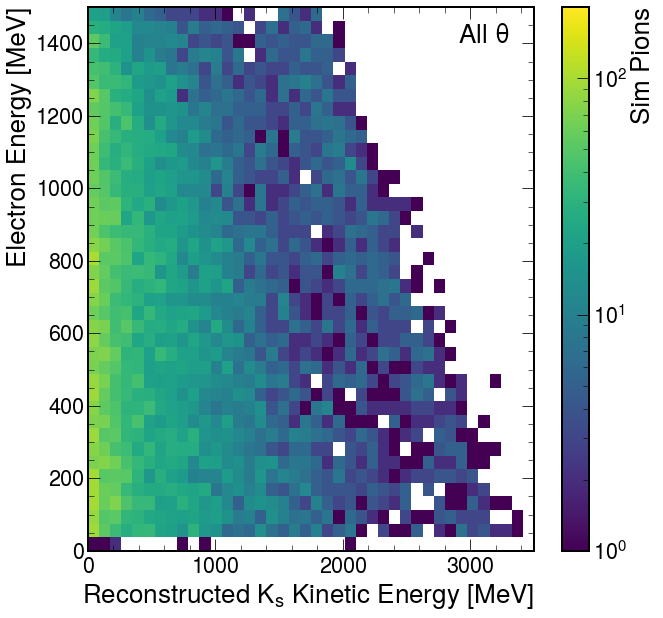

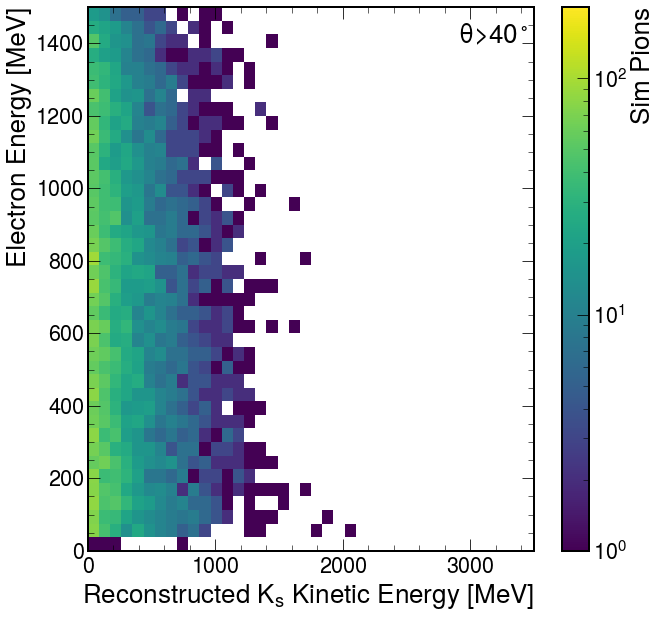

In [8]:
print(hists["sim_kaone_hist"])

fig, ax = plt.subplots()
hist.plot2d(hists["sim_kaone_hist"], xaxis='k', ax=ax, patch_opts=POPTS);
ax.text(2900, 1400,r'All $\theta$')

fig, ax = plt.subplots()
hist.plot2d(hists["sim_kaone_hist_thetacut"], xaxis='k', ax=ax, patch_opts=POPTS);
ax.text(2900, 1400,r'$\theta$>40$^\circ$')

x = np.arange(0, 3250, 1)
#ytest = -0.97* x + 3350
#ax.plot(x, ytest, '-')

#y0 = -x
#y1 = (-4.35*(x)+2150)80% is above
#y2 = (-3.35*(x)+2150)60% is above
#y3 = (-2.50*(x)+2150)40% is above
#y4 = (-1.75*(x)+3350)20% is above
#y5 = (-0.97*(x)+3350)3% is above
#y6 = -1*x+3350

y0 = -x
y1 = (-4.35*(x)+2150)
y2 = (-3.35*(x)+2150)
y3 = (-2.50*(x)+2150)
y4 = (-1.75*(x)+3350)
y5 = (-0.97*(x)+3350)
y6 = (3350)

In [9]:
print(hists["Target_kaone_hist"])

fig, ax = plt.subplots()
hist.plot2d(hists["Target_kaone_hist"].integrate('Ktype', ['Kshort']), xaxis='k', ax=ax, patch_opts=POPTS);
x = np.arange(0, 3250, 1)
ytest = (-1.25*(x)+2660)
#ax.plot(x, ytest, '-')


fig, ax = plt.subplots()
ax.set_xlim(0, 3500)
ax.set_ylim(0, 1400)
y0 = -x
y1 = (-4.35*(x)+2150)
y2 = (-3.35*(x)+2150)
y3 = (-2.50*(x)+2150)
y4 = (-1.75*(x)+3350)
y5 = (-0.97*(x)+3350)
y6 = (3350)
ax.plot(x, y5, '-')

ax.fill_between(x, y0, y1, where=(y1 > y0), facecolor='red', alpha=0.5)
ax.fill_between(x, y1, y2, where=(y2 > y1), facecolor='orange', alpha=0.5)
ax.fill_between(x, y2, y3, where=(y3 > y2), facecolor='yellow', alpha=0.5)
ax.fill_between(x, y3, y4, where=(y4 > y3), facecolor='green', alpha=0.5)
ax.fill_between(x, y4, y5, where=(y5 > y4), facecolor='blue', alpha=0.5)
#ax.fill_between(x, y5, y6, where=(y6 > y5), facecolor='yellow', alpha=0.5)
ax.set_ylabel('Electron Energy (MeV)', loc='top')
ax.set_xlabel('Kaon Kinetic Energy (MeV)', loc='right')
ax.text(50, 200, '20%')
ax.text(400, 100, '20%')
ax.text(500, 300, '20%')
ax.text(1200, 200, '20%')
ax.text(2500, 200, '20%')




KeyError: 'Target_kaone_hist'